# 1. Introduction
This notebook covers some basic EDA such as checking the training data for outliers and missing values, determining the structure of the test items and how they were generated, and plotting some sales trends over time and separated according to shops and item categories.  

It also describes a kind of data leakage in the test items that I haven't seen described before. Nothing game-changing, but kind of interesting.

# 2. Data validity checks, outliers and cleaning

Perform the imports, load the data and merge it with the item, category and shop tables

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os

Load the data, convert the date field to the datetime datatype to enable extra features, merge the item categories frame with the items and sales frames to enable sorting by item category.


In [2]:
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
test = test.merge(items, on="item_id", how="left")
test = test.merge(item_categories, on="item_category_id", how="left")
# Convert date field to datetime dtype
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

Let's have a quick look at the train data

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


The training data seems to be date-specific sales figures for specific items in specific shops, only containing entries for date-item-shop combinations for which sales occurred.

In [4]:
print(f"There are {(train['item_cnt_day']==0).sum()} training items with zero sales")

There are 0 training items with zero sales


Check for duplicated rows and missing values.

In [5]:
cols_with_na = [col for col in train if train[col].isna().sum()>0]
print(f"The following columns have missing values: {cols_with_na}")
print(f"There are {train.duplicated().sum()} duplicated rows out of a total of {train.shape[0]} rows.")

The following columns have missing values: []
There are 6 duplicated rows out of a total of 2935849 rows.


No missing values, good! The duplicated rows are no big deal, but we can remove them anyway.

In [6]:
train = train.drop_duplicates()

Boxplots of item counts and prices

Mean and 99.9th quantile of "item_cnt_day" are 1.24 and 22.00
Mean and 99.9th quantile of "item_price" are 890.85 and 23990.00


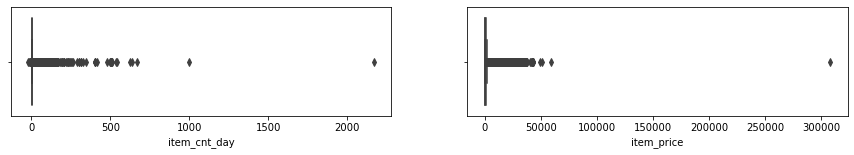

In [7]:
print(f'Mean and 99.9th quantile of "item_cnt_day" are {train.item_cnt_day.mean():.2f} and {train.item_cnt_day.quantile(0.999):.2f}')
print(f'Mean and 99.9th quantile of "item_price" are {train.item_price.mean():.2f} and {train.item_price.quantile(0.999):.2f}')
fig, axes = plt.subplots(1,2, figsize = (15,2))
_ = sns.boxplot(x=train.item_cnt_day, ax=axes[0])
_ = sns.boxplot(x=train.item_price, ax=axes[1])

There appear to be a few outliers which might distort the model. We can have a quick look at the highest-selling items.

In [8]:
train.sort_values('item_cnt_day', ascending=False).head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
2909818,2015-10-28,33,12,11373,0.908714,2169.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара
2326930,2015-01-15,24,12,20949,4.000000,1000.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2864235,2015-09-30,32,12,9248,1692.526158,669.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты
2851091,2015-09-30,32,55,9249,1702.825746,637.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра)
2608040,2015-04-14,27,12,3731,1904.548077,624.0,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания


The top 5 items appear to include a generic item for delivery charges, a promotional t-shirt, tickets for a gaming exhibition, and Grand Theft Auto V, presumably on its release date. Deciding what to do with these items is tricky, as they may distort the model if not removed from the training data, but if similar high-selling items are in the test set then there will be a large penalty for failing to correctly predict them.

Remove the outliers and items with negative prices (there is only one, but it might have strange effects when engineering features).

In [9]:
train[train.item_price<0]
train = train[(train.item_price < train.item_price.quantile(0.99999)) & (train.item_price > 0)]
train = train[train.item_cnt_day < train.item_cnt_day.quantile(0.99999)]

# 3. Determining the structure of the test dataset

In [10]:
test.head(5)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4


The train and test data as provided are mismatched, as the train data consists of per-day entries, while the test items are aggregated to the month level.  

A little exploration finds that each of the shop_ids is paired with the exact same set of item_ids. This suggests that the entries are the Cartesian product (i.e. all possible combinations) of a set of shops and items, which can be validated by checking the value counts of the shop_id and item_id's.

In [11]:
print(f"There are {len(test['shop_id'].unique())} unique shop_id's and {len(test['item_id'].unique())} unique item_id's in the test set.")
print(f"There are {len(test)} test items in total.")

There are 42 unique shop_id's and 5100 unique item_id's in the test set.
There are 214200 test items in total.


So there are 42 shop_ids and 5100 item_ids, 42 x 5100 = 214,200, the number of rows in the test table.

A reasonable assumption would be that the shops and items in the test set are those items for which there were at least one sale in the test month. A quick check of the validity of this is to the compare the number of unique items in the test month with the unique items in each month of the train set and see if they are similar. We can plot this.

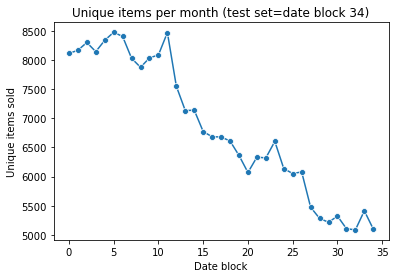

In [12]:
unique_items_date_block = [train.loc[train.date_block_num==x,:].item_id.unique().size for x in range(34)]
unique_items_date_block.append(test.item_id.unique().size)
ax = sns.lineplot(x = range(len(unique_items_date_block)), y = unique_items_date_block, marker='.', markersize=12)
_ = ax.set(xlabel = "Date block", ylabel = "Unique items sold", title = "Unique items per month (test set=date block 34)")

The number of unique test item_id's is close to those in preceding months. A trend of decreasing numbers of unique items in each month is clear. If this trend of decreasing unique items is related to sales trends in general, this implies a kind of data leak in the test table.  

It might be interesting to check how many of the items sold in previous months correspond to the items in the test data. We can check the intersection of the sets of these items.

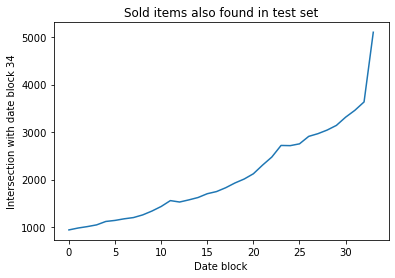

In [13]:
intersection = [len(set(train.loc[train.date_block_num==x,:].item_id).intersection(set(test.item_id))) for x in range(33)]
intersection.append(len(set(test.item_id)))
ax = sns.lineplot(x = range(len(intersection)), y = intersection)
_ = ax.set(xlabel = "Date block", ylabel = "Intersection with date block 34")
_ = ax.set_title("Sold items also found in test set")

This plot shows that the items sold in each month become more similar to those in the test set the closer the month is in time (as should be expected), but also that there are quite a lot of items in the test set which did not appear in the preceding month.  

We can check if this is some kind of anomaly by calculating how much the set of sold items changes each month.

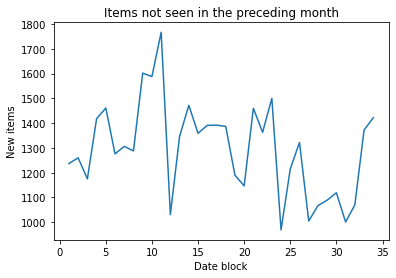

In [14]:
intersection = [len(set(train.loc[train.date_block_num==i+1,:].item_id) - 
    set(train.loc[train.date_block_num==i,:].item_id)) for i in range(33)]
intersection.append(len(set(train.loc[train.date_block_num==33].item_id) - set(test.item_id)))
ax = sns.lineplot(x = range(1, len(intersection)+1), y = intersection)
_ = ax.set(xlabel = "Date block", ylabel = "New items")
_ = ax.set_title("Items not seen in the preceding month")

So the test set is average in this respect. The hypothesis that the set of item_id's in the test set is those that recorded a sale seems sound.

The following function reformats the training data to the same format as the test table, i.e. the Cartesian product of all items and shops that record at least one sale in each monthly date block.

In [15]:
def create_testlike_train(sales_train, test=None):
    # Create a date_block_num / item_id / shop_id index using all combinations of item_id and shop_id occurring within each date_block
    # Optionally concatenate the test items to the end
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = (
        sales_train["item_price"] * sales_train["item_cnt_day"]
    )

    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(
        ["date_block_num", "shop_id", "item_id"]
    ).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(
            column="item_revenue_day", aggfunc="sum"
        ),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped,
        how="left",
        on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [16]:
matrix = create_testlike_train(train)
# Adding item category column to allow sorting by category later
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
matrix.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_category_id
0,0,59,22154,1.0,999.0,37
1,0,59,2552,0.0,0.0,58
2,0,59,2554,0.0,0.0,58
3,0,59,2555,0.0,0.0,56
4,0,59,2564,0.0,0.0,59


# 4. Exploring the training data

## 4.1 Overall sales trends
Plotting total sales counts per month shows clear downwards and seasonal trends. However the mean number of each item sold per month (which is what is to be predicted) shows a less pronounced downwards trend.


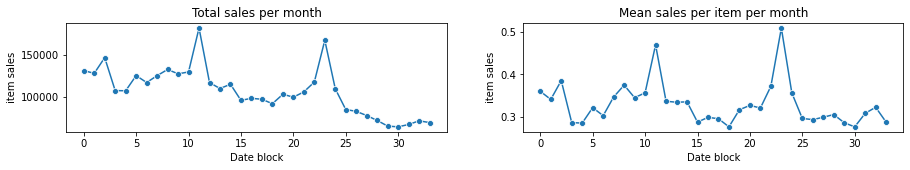

In [17]:
sales_by_month = matrix.groupby('date_block_num').item_cnt_month.sum()
fig, axes = plt.subplots(1,2, figsize = (15,2))
ax = sns.lineplot(data=sales_by_month, marker='.', markersize=12, ax=axes[0])
_ = ax.set(xlabel = "Date block", ylabel = "item sales", title = "Total sales per month")
sales_by_month = matrix.groupby('date_block_num').item_cnt_month.mean()
ax = sns.lineplot(data=sales_by_month, marker='.', markersize=12, ax=axes[1])
_ = ax.set(xlabel = "Date block", ylabel = "item sales", title = "Mean sales per item per month")

Mean sales per item can also be decomposed into seasonal and continuous trends, which shows the clear seasonal trend (i.e. a peak around the winter holidays) and a mild overall downwards trend that levels out.

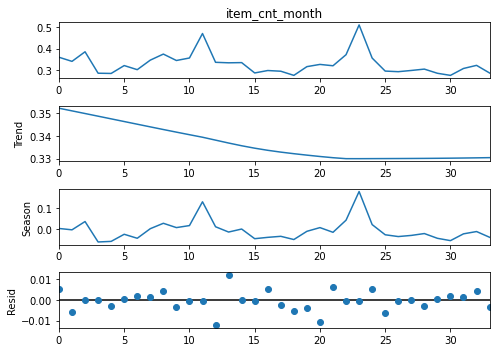

In [18]:
from statsmodels.tsa.seasonal import STL
result = STL(sales_by_month, period=12).fit()
fig = result.plot()
fig.set_size_inches((7,5))
fig.tight_layout()

## 4.3 Sales as a function of item age
Plotting items as a function of their age indicates that they tend to sell most when they are new and then decline to a plateau about 1 year later. Item age is calculated here as the number of months since the month of their first appearence in the data. The slightly lower sales in the first compared to the second month is attributable to items not always being available for the whole month during their first calendar month of availability.  

The corresponding plot of sales according to shop age shows no such trend

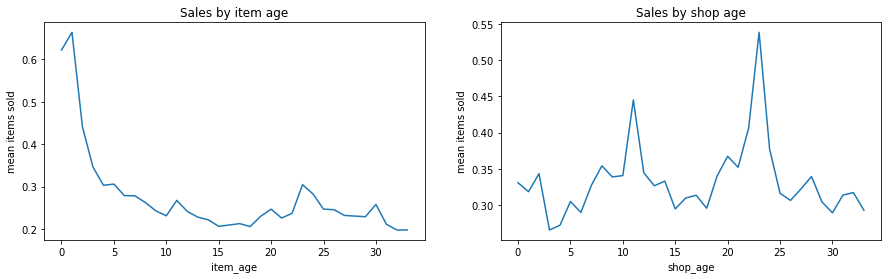

In [19]:
def item_shop_age_months(matrix):
    matrix["item_age"] = matrix.groupby("item_id")["date_block_num"].transform(
    lambda x: x - x.min()
    )
    matrix["new_item"] = matrix["item_age"] == 0
    matrix["new_item"] = matrix["new_item"].astype("int8")
    matrix["shop_age"] = (
        matrix.groupby("shop_id")["date_block_num"]
        .transform(lambda x: x - x.min())
        .astype("int8")
    )
    matrix["new_shop"] = matrix.shop_age == 0
    matrix["new_shop"] = matrix["new_shop"].astype("int8")
    return matrix

matrix = item_shop_age_months(matrix)

fig, axes = plt.subplots(1,2, figsize = (15,4))
ax = matrix.groupby('item_age').item_cnt_month.mean().plot(
    ylabel='mean items sold', title='Sales by item age', ax=axes[0])
ax = matrix.groupby('shop_age').item_cnt_month.mean().plot(
    ylabel='mean items sold', title='Sales by shop age', ax=axes[1])

## 4.2 Sales by shop
We can plot mean sales per item over time separately for each of the shops. The names of these are in Russian, for clarity I added translations into English from google translate.

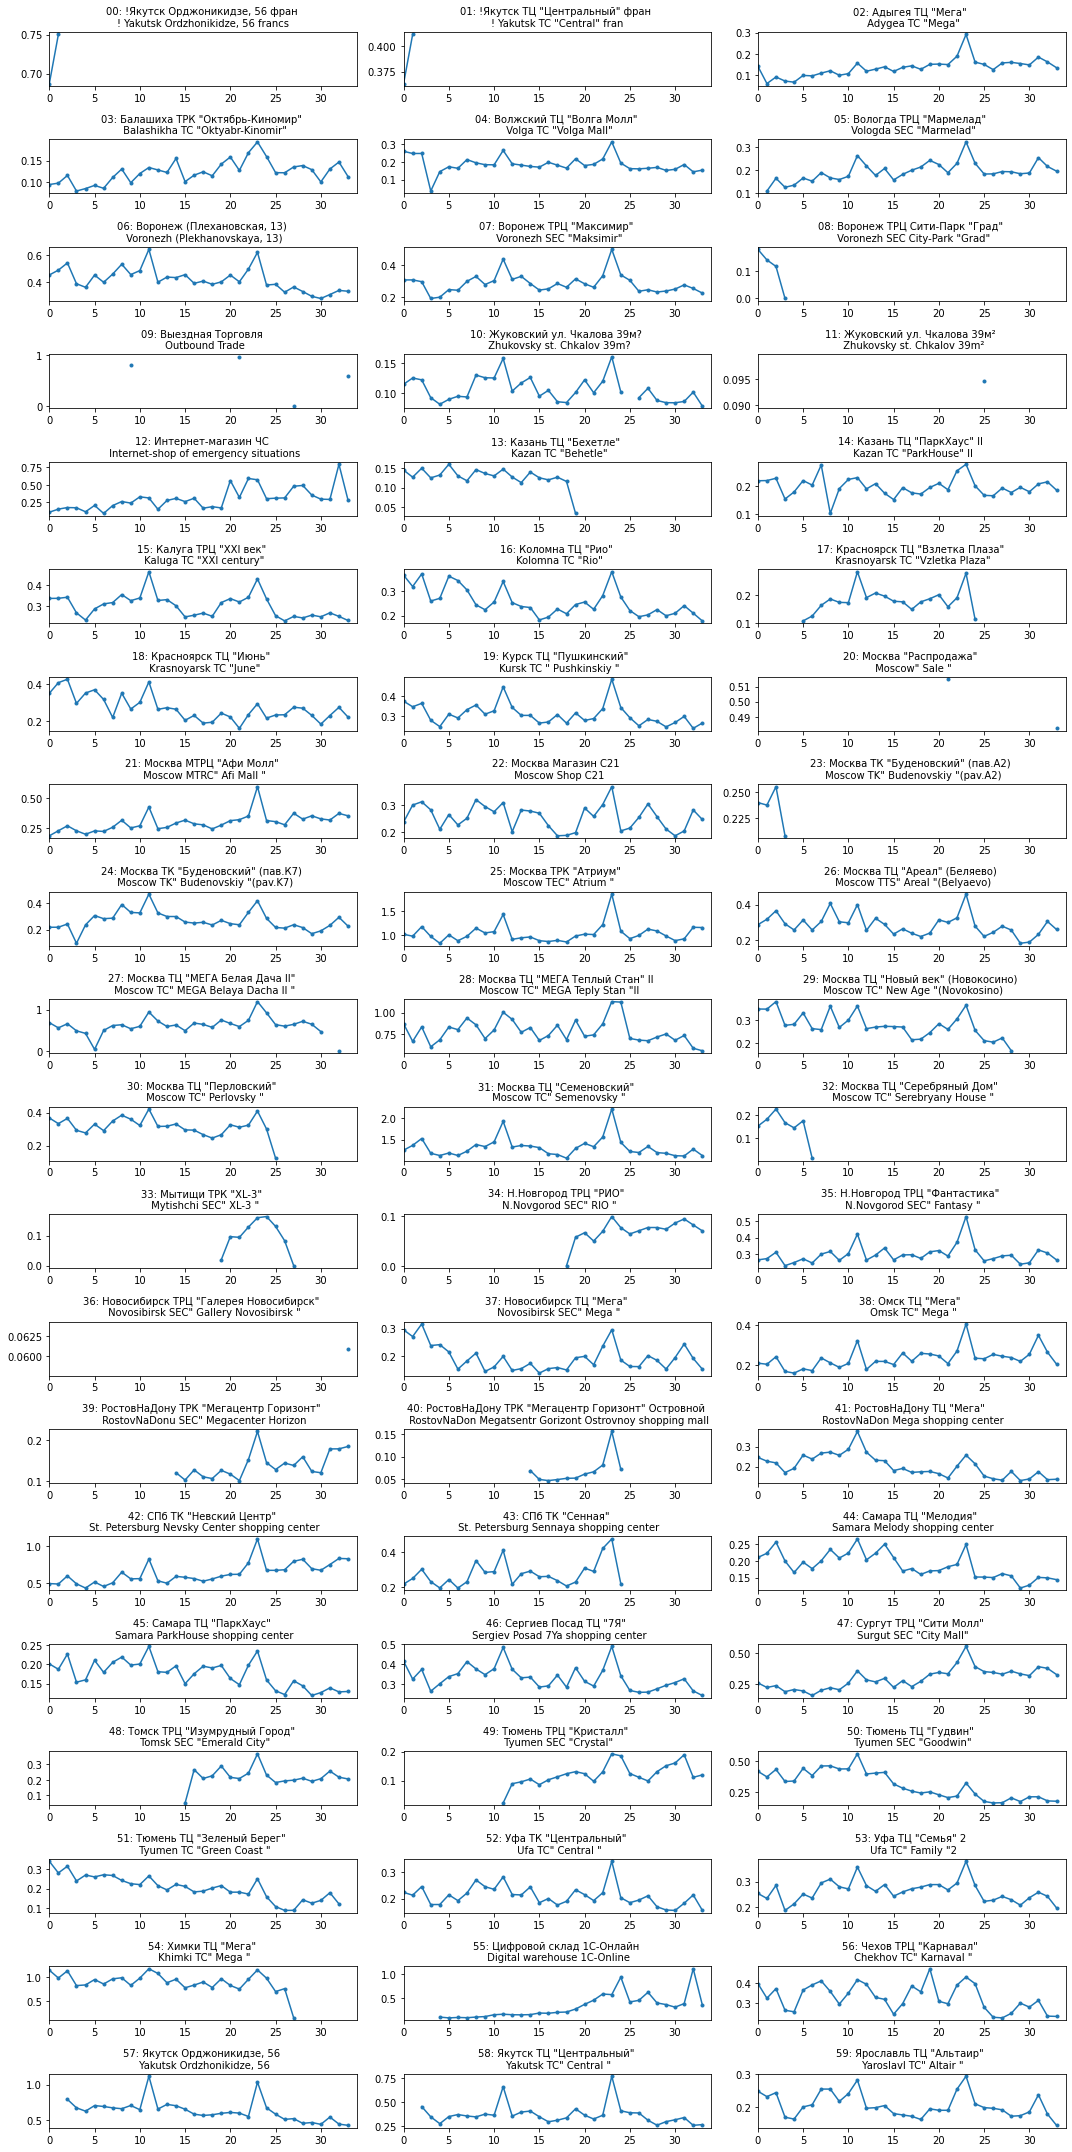

In [20]:
shops = pd.read_csv("../input/predict-future-sales-extra/shops_extra.csv")
shops['shop_name_trans'] = shops['shop_name'] + " \n" + shops['shop_name_en']
shopnamedict = { id : f"{id:02}: {name}" for name, id in zip(list(shops['shop_name_trans']), list(shops['shop_id']))}

ts = matrix.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean()
ts = ts.reset_index()
ts['shop_name_trans'] = ts['shop_id'].map(shopnamedict)
tsp = ts.pivot(index='date_block_num',columns='shop_name_trans',values='item_cnt_month')

fig, axes = plt.subplots(20,3, figsize=(15,30))
for i, shop_name in enumerate(tsp.columns):
    idx = divmod(i,axes.shape[1])
    axes[idx[0]][idx[1]].plot(tsp.index,tsp.loc[:,shop_name], marker='.')
    axes[idx[0]][idx[1]].set_xlim(0,34)
    axes[idx[0]][idx[1]].set_title(shop_name, fontsize=10)
fig.tight_layout()

There are several important things to note here.

* Several shops have been recorded under 2 different IDs and should be combined (0-57, 1-58 and 10-11). Other shops are only open for a short time and may be better removed.
* Some shops appear to be online only (e.g. 12) or occasional special categories rather than physical shops (e.g. 9 and 20).
* Finally, it can be noted that almost all shop names start with the name of the city in which the shop is located - this could be used as a feature.

In [21]:
# Correct shop labels
train.loc[train.shop_id == 0, "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
# Drop special categories
train = train.loc[(train.shop_id != 9) & (train.shop_id != 20), :]
# Remove data from short-lived shops
shops_to_remove = [8, 23, 32, 33, 40]
train = train.loc[~train["shop_id"].isin(shops_to_remove), :]

Some shops closed during the period covered by the training data and are included in the test set. These could be removed to potentially improve test performance.

In [22]:
print(f"There are {len(set(test.shop_id) - set(train.shop_id))} shops in the test set that are not in the train set")
print(f"There are {len(set(train.shop_id) - set(test.shop_id))} shops in the train set that are not in the test set")

There are 0 shops in the test set that are not in the train set
There are 8 shops in the train set that are not in the test set


## PCA decomposition and clustering of shops  
Principle component analysis lets us simplify high dimensional data into low-dimensional features and so make it easier to understand. We can do this with the sales of items in shops to try to understand their similarities and differences.  

The next cell calculates the number of items sold in each category for each shop and performs PCA on this data. Plotted is the amount of variation between shops explained by each component and the shops projections onto the first two components.  

The explained variance plot shows that over 80% of the differences between the shops correspond to a general component representing the overall volume of item sales. The scatterplot indicates that shop 55 and possibly shop 12 have a different sales profile to the other shops - this makes sense because these shops are online.

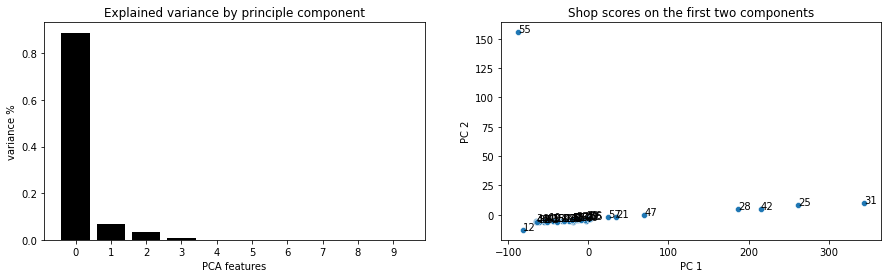

In [23]:
from sklearn.decomposition import PCA

def plot_pca(data, n_components):
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(data)
    components = pd.DataFrame(components)
    # Plot the explained variances
    features = range(pca.n_components_)
    fig, axes = plt.subplots(1,2, figsize = (15,4))
    _ = axes[0].bar(features, pca.explained_variance_ratio_, color='black')
    _ = axes[0].set_xlabel('PCA features')
    _ = axes[0].set_ylabel('variance %')
    _ = axes[0].set_xticks(features)
    _ = axes[0].set_title("Explained variance by principle component")
    # Plot the shops according to their projection
    x = components[0]
    y = components[1]
    sns.scatterplot(x=x, y=y, ax=axes[1])
    axes[1].set_xlabel('PC 1')
    axes[1].set_ylabel('PC 2')
    axes[1].set_title('Shop scores on the first two components')
    for i, txt in enumerate(data.index.to_list()):
        axes[1].annotate(str(txt), (x[i], y[i]))

start_month=21
end_month=33
pt = matrix[matrix.shop_id.isin(test.shop_id.unique())].query(f"date_block_num>{start_month} & date_block_num<={end_month}")
pt = pt.pivot_table(values='item_cnt_month', columns='item_category_id', index='shop_id', fill_value=0, aggfunc='mean')
plot_pca(pt, 10)     

If we perform the same operations again with the digital shops removed we see that almost all the differences between the shops are on a single dimension, and there are a small number of shops with much higher values in this dimensions. These groups of shops could potentially be marked as some kind of cluster feature.

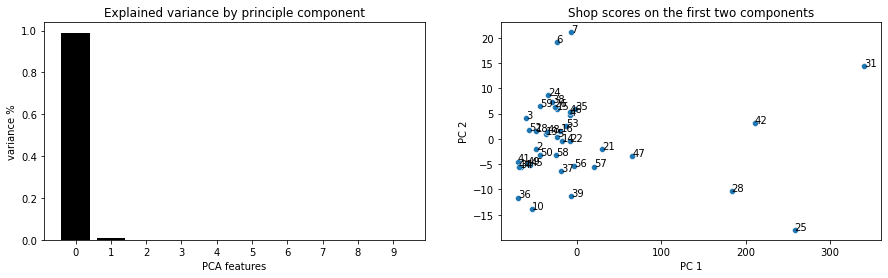

In [24]:
pt = matrix[matrix.shop_id.isin(test.shop_id.unique())].query(f"date_block_num>{start_month} & date_block_num<={end_month} & shop_id!=55 & shop_id!=12")
pt = pt.pivot_table(values='item_cnt_month', columns='item_category_id', index='shop_id', fill_value=0, aggfunc='mean')
plot_pca(pt, 10)     

## 4.3 Sales by category and possible data leakage  

Mean item sales can also be separated out according to category. As with the shop names, category names were translated to English.  

For comparison, the number of unique items in each category is plotted on the same axis (in orange), to explore the possibility that this has a meaningful relationship to sales. As can been seen from the plots, there is a clear relationship, although this varies by item category.

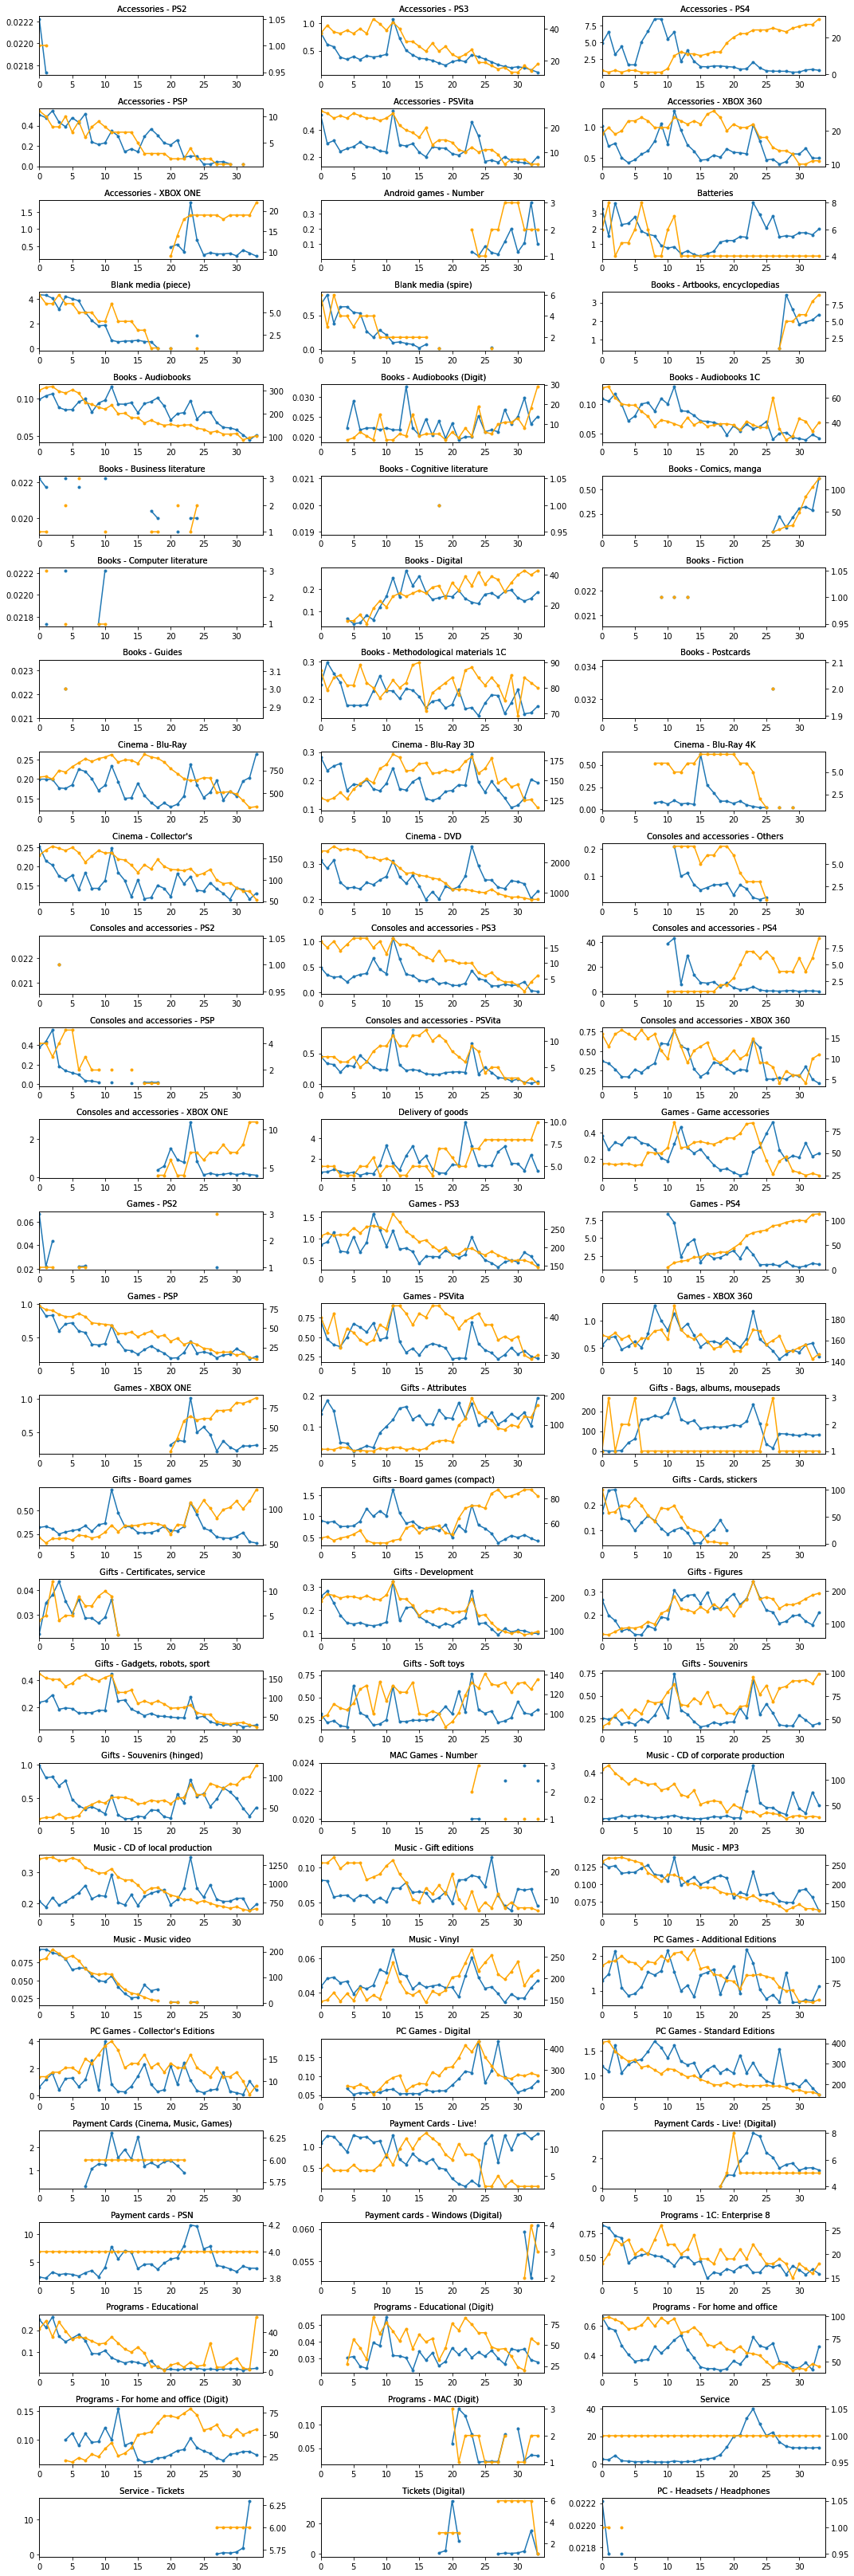

In [25]:
item_categories = pd.read_csv("../input/predict-future-sales-extra/item_categories_enhanced.csv")
unique_id_cat = (
    train.groupby(["date_block_num", "item_category_id"])
    .item_id.nunique()
    .rename("unique_items_cat")
    .reset_index()
)
unique_id_cat = unique_id_cat.merge(item_categories[['item_category_id', 'category_name']],
                                    on='item_category_id', how='left')

unique_items_cat_ts = unique_id_cat.pivot(
    index="date_block_num", columns="category_name", values="unique_items_cat"
)

# Create a time series of mean sales per item by category
m = matrix.merge(items.drop(columns='item_category_id'), on='item_id', how='left')
m = m.merge(item_categories, on='item_category_id', how='left')
ts = m.groupby(["date_block_num", "category_name"])["item_cnt_month"].mean().reset_index()

sales_cat = ts.pivot(
    index="date_block_num", columns="category_name", values="item_cnt_month"
)

# Plot both series for all categories
fig, axes = plt.subplots(28, 3, figsize=(15, 45))
for i, cat_name in enumerate(sales_cat.columns):
    idx = divmod(i, axes.shape[1])
    axes[idx[0]][idx[1]].plot(sales_cat.index, sales_cat.loc[:, cat_name], marker=".")
    axes[idx[0]][idx[1]].set_xlim(0, 34)
    axes[idx[0]][idx[1]].set_title(cat_name, fontsize=10)
    ax2 = axes[idx[0]][idx[1]].twinx()
    ax2.plot(
        unique_items_cat_ts.index,
        unique_items_cat_ts.loc[:, cat_name],
        marker=".",
        color="orange",
    )
    ax2.set_xlim(0, 34)
    ax2.set_title(cat_name, fontsize=10)
fig.tight_layout()

For clarity: mean item sales are in blue with the y axis on the left, and the orange line is the number of unique items in that category in that monthly date block.

There is a lot of information here : 
* From the names of the categories it looks like they could be grouped together into supercategories to create extra features, e.g. "games"
* Some categories contain very few items or sales and could potentially be removed or combined with other categories.
* Some categories become obsolete over time and could potentially be removed from the training data.

## 4.4 Proportions of categories in train and test sets

It is fairly easy to manually group the 83 categories into more general supercategories like games, music etc. These have been saved in a csv table and can be used to clarify the makeup of items in the train and test sets.

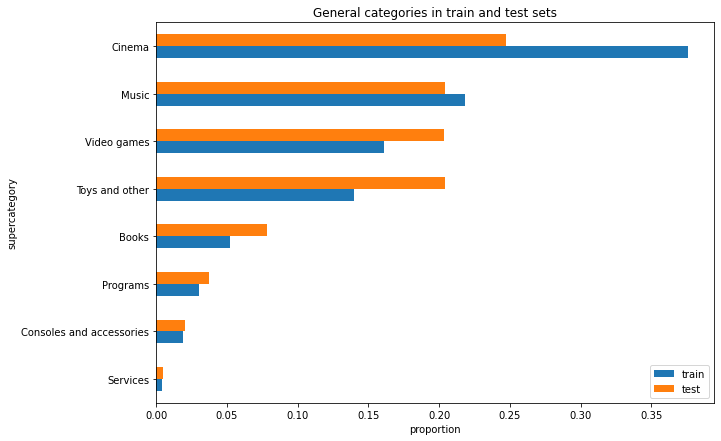

In [26]:
t = test.merge(item_categories[['item_category_id', 'supercategory']], on='item_category_id', how='left')
cat_proportions_train = m.groupby('supercategory').item_category_id.count()
cat_proportions_train = cat_proportions_train.rename('train')
cat_proportions_train = pd.DataFrame(cat_proportions_train)

cat_proportions_test = t.groupby('supercategory').item_category_id.count()
cat_proportions_test = cat_proportions_test.rename('test')
cat_proportions = cat_proportions_train.merge(cat_proportions_test, left_index=True, right_index=True)
cat_proportions = cat_proportions.sort_values('train', ascending=True)
cat_proportions = cat_proportions.transform(lambda x: x / x.sum())
ax = cat_proportions.plot.barh(figsize=(10,7))
_ = plt.title('General categories in train and test sets')
_ = plt.xlabel('proportion')

* From this we can see that most of the items are cinema, music, games or toys. Efforts to improve prediction on these categories of item are likely to be the most profitable.

* From this chart it is evident that the distribution of item types is different in the train and test sets. Compensating for this in some way may improve performance.


## 4.5 Relationship between price and sales
* **Prices and sales counts are highly skewed**  

The price of items is included in the training data and might be expected to be related to sales. We can plot the price and sales numbers of items in training matrix in a scatter plot, but the sales counts and prices are heavily skewed towards the lower end and are too numerous to see clearly.

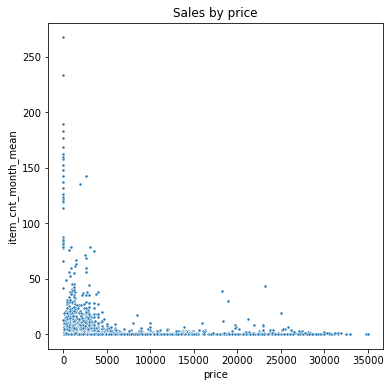

In [27]:
itemsales = matrix.groupby(["date_block_num", "item_id"]).agg(
    {"item_cnt_month": "sum", "item_revenue_month": "sum"}
)
itemsales["price"] = itemsales.item_revenue_month / itemsales.item_cnt_month
itemsales = itemsales.drop(columns=["item_cnt_month", "item_revenue_month"])
itemsales["item_cnt_month_mean"] = matrix.groupby(["date_block_num", "item_id"]).item_cnt_month.mean()
itemsales = itemsales.loc[slice(0, 33), slice(None), :]

# Calculating prices in this way produces some negative and infinite values, these can be removed
itemsales = itemsales.drop(itemsales['price'][(itemsales['price']==np.inf) | (itemsales['price']<=0)].index)
itemsales = itemsales.drop(itemsales['item_cnt_month_mean'][(itemsales['item_cnt_month_mean']<=0)].index)

# Plot mean sales
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax = sns.scatterplot(data=itemsales, x='price', y='item_cnt_month_mean', marker='.')
_ = ax.set_title('Sales by price')

* **Lower priced items tend to sell less, which can be related to price reductions for older, less popular items**  

The trends are clearer if items are binned by price and mean values are calculated for bins, as below. Also plotted below are trends for item prices relative to other items in the same category, and relative to the mean price of the same item over all months.  

Also shown is a plot of mean price by item age, which shows that items tend to fall in price with time.

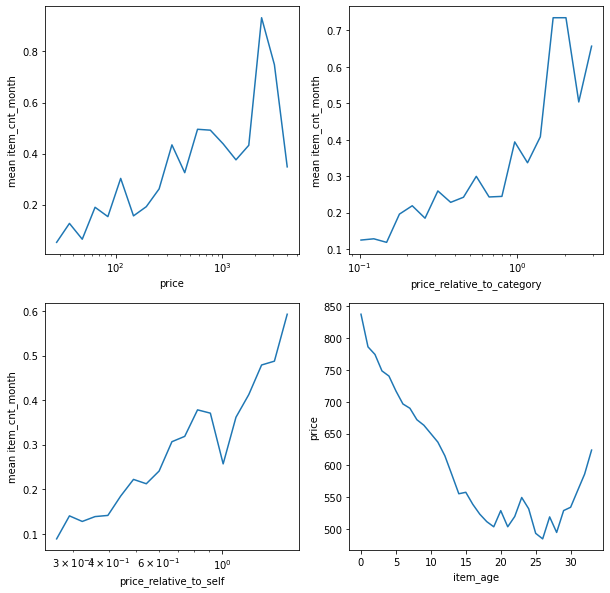

In [28]:
itemsales = itemsales.reset_index()
itemsales["item_age"] = itemsales.groupby("item_id")["date_block_num"].transform(
lambda x: x - x.min()
)
itemsales = itemsales.merge(items[['item_id','item_category_id']], how='left', on='item_id')
itemsales = itemsales.merge(item_categories, how='left', on='item_category_id')

itemsales['price_relative_to_category'] = itemsales.groupby(['date_block_num','item_category_id'])['price'].transform(lambda x: x / x.mean())
itemsales['price_relative_to_self'] = itemsales.groupby(['item_id'])['price'].transform(lambda x: x / x.mean())

def calc_bin_means(feature_name):
    feature = itemsales[feature_name]
    mybins=np.logspace(np.log10(feature.quantile(0.01)), np.log10(feature.quantile(0.99)),20)
    bin_means, bin_edges, binnumber = stats.binned_statistic(feature, itemsales['item_cnt_month_mean'],
        statistic='mean', bins=mybins)
    bin_widths = np.diff(bin_edges)
    return (bin_means, bin_edges, binnumber)

feats = ['price', 'price_relative_to_category', 'price_relative_to_self']
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()
for i, feature_name in enumerate(feats):
    bin_means, bin_edges, binnumber = calc_bin_means(feature_name)
    sns.lineplot(x=bin_edges[:-1], y=bin_means, ax=axes[i])
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('mean item_cnt_month')
    axes[i].set_xscale('log')
_ = sns.lineplot(data=itemsales.groupby("item_age").price.mean(), ax=axes[3])

### 4.5.1 Effect of outliers  
* **Price trends are obscured by outliers**  

Finally, the above plots were made excluding the highest and lowest 1% of items by price. When these are included, the plots look very diffeent and the central trend is not so obvious.  

This seems to reinforce the point that outliers could distort predictions if not removed from the data.

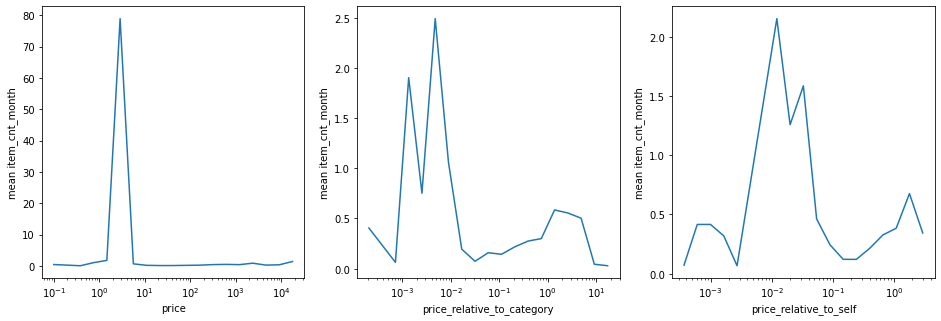

In [29]:
def calc_bin_means(feature_name):
    feature = itemsales[feature_name]
    mybins=np.logspace(np.log10(feature.min()), np.log10(feature.max()),20)
    bin_means, bin_edges, binnumber = stats.binned_statistic(feature, itemsales['item_cnt_month_mean'],
        statistic='mean', bins=mybins)
    bin_widths = np.diff(bin_edges)
    return (bin_means, bin_edges, binnumber)

feats = ['price', 'price_relative_to_category', 'price_relative_to_self']
fig, axes = plt.subplots(1,3, figsize=(16,5))
for i, feature_name in enumerate(feats):
    bin_means, bin_edges, binnumber = calc_bin_means(feature_name)
    sns.lineplot(x=bin_edges[:-1], y=bin_means, ax=axes[i])
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('mean item_cnt_month')
    axes[i].set_xscale('log')